<a href="https://colab.research.google.com/github/Gltknzk/Data-Quality-/blob/master/Quality_Inspector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**---------------------- DATA QUALITY METRICS----------------------**
1. Completeness
This measures whether all the necessary data is present in a specific dataset. You can think about completeness in one of two ways: at the record level or at the attribute level. Measuring completeness at the attribute level is a little more complex however, as not all fields will be mandatory.

2. Accuracy
How accurately does your data reflect the real-world object? In the financial sector, data accuracy is usually black or white – it either is or isn’t accurate. That’s because the number of pounds and pennies in an account is a precise number.
Data accuracy is critical in large organizations, where the penalties for failure are high.

3. Consistency
Maintaining synchronicity between different databases is essential. To ensure data remains consistent on a daily basis, software systems are often the answer.

4. Validity
Validity is a measure of how well data conforms to required value attributes. For example, ensuring dates conform to the same format, i.e., date/month/year or month/date/year.

5. Timeliness
Timeliness reflects the accuracy of data at a specific point in time. An example of this is when a customer moves to a new house, how timely are they in informing their bank of their new address? Few people do this immediately, so there will be a negative impact on the timeliness of their data.

6. Integrity
To ensure data integrity, it’s important to maintain all the data quality metrics we’ve mentioned above as your data moves between different systems. Typically, data stored in multiple systems breaks data integrity.

In order to measure the quaily of a dataset, It may be helpful to analyze missing values, duplicated values, multicolinearity and erroraneous values for a given dataset.  



# Importing Libraries

In [33]:
import pandas_profiling
import pyforest

import ipywidgets
from ipywidgets import interact

import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mticker

# Importing plotly and cufflinks in offline mode
import plotly.express as px
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

!pip install termcolor
from termcolor import colored
from termcolor import cprint

from wordcloud import WordCloud

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno 

import datetime as dt
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor 
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, f_regression, mutual_info_regression
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import plot_confusion_matrix, r2_score, mean_absolute_error, mean_squared_error, classification_report 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import make_scorer, precision_score, precision_recall_curve, plot_precision_recall_curve 
from sklearn.metrics import plot_roc_curve, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score
from sklearn.model_selection import RepeatedStratifiedKFold, KFold, cross_val_predict, train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, PowerTransformer, LabelEncoder 
from sklearn.svm import SVR, SVC
from sklearn.tree import plot_tree, DecisionTreeClassifier

from xgboost import XGBRegressor, XGBClassifier, plot_importance

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
from ydata_quality import DataQuality

In [35]:
!pip install pyforest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Functions for Data Summary

In [15]:
def Data_Summary(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('*'*100, 'red', attrs = ['bold']),
          colored("\nInfo:\n", attrs = ['bold']), sep = '')
    print(df.info(), '\n', 
          colored('*'*100, 'red', attrs = ['bold']), sep = '')
    print(colored("Number of Uniques:\n", attrs = ['bold']), df.nunique(),'\n',
          colored('*'*100, 'red', attrs = ['bold']), sep = '')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('*'*100, 'red', attrs = ['bold']), sep = '')
    print(colored("All Columns:", attrs = ['bold']), list(df.columns),'\n', 
          colored('*'*100, 'red', attrs = ['bold']), sep = '')

    df.columns = df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')
    print(colored("Columns after rename:", attrs = ['bold']), list(df.columns),'\n',
          colored('*'*100, 'red', attrs = ['bold']), sep = '')  
    print(colored("Descriptive Statistics \n", attrs = ['bold']), df.describe().round(2),'\n',
          colored('*'*100, 'red', attrs = ['bold']), sep = '') # Gives a statstical breakdown of the data.
    print(colored("Descriptive Statistics (Categorical Columns) \n", attrs = ['bold']), df.describe(include = object).T,'\n',
          colored('*'*100, 'red', attrs = ['bold']), sep = '') # Gives a statstical breakdown of the data.

# Functions for Missing Values, Multicolinearity and Duplicated Values

In [17]:
def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending = False)
    missing_percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending = False)
    missing_values = pd.concat([missing_number, missing_percent], axis = 1, keys = ['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number'] > 0]

In [99]:
def multicolinearity_control(df):
  feature = []
  collinear = []
  for col in df.corr().columns:
    for i in df.corr().index:
      if (abs(df.corr()[col][i]) > .9 and abs(df.corr()[col][i]) < 1):
        feature.append(col)
        collinear.append(i)
        print(colored(f"Multicolinearity alert in between:{col} - {i}", 
                                  "red", attrs = ['bold']), df.shape,'\n',
                                  colored('*'*100, 'red', attrs = ['bold']), sep = '')

def duplicate_values(df):
    print(colored("Duplicate check...", attrs = ['bold']), sep = '')
    print("There are", df.duplicated(subset = None, keep = 'first').sum(), "duplicated observations in the dataset.")
    duplicate_values = df.duplicated(subset = None, keep = 'first').sum()
    #if duplicate_values > 0:
        #df.drop_duplicates(keep = 'first', inplace = True)
        #print(duplicate_values, colored(" Duplicates were dropped!"),'\n',
              #colored('*'*100, 'red', attrs = ['bold']), sep = '')
#     else:
#         print(colored("There are no duplicates"),'\n',
#               colored('*'*100, 'red', attrs = ['bold']), sep = '')     
        
# def drop_columns(df, drop_columns):
#     if drop_columns != []:
#         df.drop(drop_columns, axis = 1, inplace = True)
#         print(drop_columns, 'were dropped')
#     else:
#         print(colored('We will now check the missing values and if necessary, the related columns will be dropped!', attrs = ['bold']),'\n',
#               colored('*'*100, 'red', attrs = ['bold']), sep = '')
        

# Loading Dataset

In [115]:
df=pd.read_csv("/content/store_sharing.csv")

# Data Summary

In [116]:
Data_Summary(df)

Shape:(17414, 10)
****************************************************************************************************
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB
None
****************************************************************************************************
Number of Uniques:
timestamp       17414
cnt              3781
t1                

# Missing Values, Multicolienaity and Duplicated Values

In [117]:
multicolinearity_control(df)

Multicolinearity alert in between:t1 - t2(17414, 10)
****************************************************************************************************
Multicolinearity alert in between:t2 - t1(17414, 10)
****************************************************************************************************


In [110]:
duplicate_values(df)

Duplicate check...
There are 0 duplicated observations in the dataset.


In [111]:
missing_values(df)

,Missing_Number,Missing_Percent


In [4]:
from ydata_quality.duplicates import DuplicateChecker

In [51]:
dc = DuplicateChecker(df=df)

In [52]:
results = dc.evaluate()
results.keys()

WARNING | There are no entities defined to run the analysis. Skipping the test.
INFO | No duplicate columns were found.
Warnings:
	TOTAL: 1 warning(s)
	Priority 2: 1 warning(s)


Priority 2 - usage allowed, limited human intelligibility:
	* [DUPLICATES - EXACT DUPLICATES] Found 5268 instances with exact duplicate feature values.



dict_keys(['exact_duplicates', 'entity_duplicates', 'duplicate_columns'])

In [53]:
# Retrieve the warnings
warnings = dc.get_warnings()

In [54]:
exact_duplicates_out = dc.exact_duplicates()
exact_duplicates_out.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/10 11:45,1.250,17908.000,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/10 11:45,2.100,17908.000,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/10 11:45,2.950,17908.000,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/10 11:45,4.950,17908.000,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,12/1/10 11:49,2.950,17920.000,United Kingdom


In [55]:
dc.duplicate_columns()

INFO | No duplicate columns were found.


In [56]:
!pip install --upgrade klib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
from ydata_quality.erroneous_data import ErroneousDataIdentifier

In [112]:
edi = ErroneousDataIdentifier(df=df)

In [113]:
edi.evaluate()

INFO | No predefined ED values from  the set {'', '(blank)', 'unknown', '?', 'n/a', 'unk', 'na'} were found in the dataset.
No warnings found.


{'predefined_erroneous_data': None}

In [114]:
edi.predefined_erroneous_data()

INFO | No predefined ED values from  the set {'', '(blank)', 'unknown', '?', 'n/a', 'unk', 'na'} were found in the dataset.


In [70]:
df.sample(10)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
128254,547250,84598,BOYS ALPHABET IRON ON PATCHES,2,3/22/11 9:30,0.210,NaN,United Kingdom
33753,539294,22834,HAND WARMER BABUSHKA DESIGN,2,12/16/10 16:45,2.100,15532.000,United Kingdom
120438,546655,20682,RED RETROSPOT CHILDRENS UMBRELLA,1,3/15/11 14:19,6.630,NaN,United Kingdom
521664,580367,22422,TOOTHPASTE TUBE PEN,2,12/2/11 16:39,1.250,NaN,United Kingdom
518587,580115,23526,WALL ART DOG LICENCE,4,12/1/11 16:22,12.460,NaN,United Kingdom
517397,580054,22142,CHRISTMAS CRAFT WHITE FAIRY,3,12/1/11 13:08,1.450,18122.000,United Kingdom
158225,550279,22138,BAKING SET 9 PIECE RETROSPOT,6,4/15/11 13:16,4.950,14700.000,United Kingdom
240897,558118,21700,BIG DOUGHNUT FRIDGE MAGNETS,6,6/27/11 9:11,1.380,NaN,United Kingdom
498176,578513,23581,JUMBO BAG PAISLEY PARK,20,11/24/11 13:32,2.080,16609.000,United Kingdom
406515,571797,22624,IVORY KITCHEN SCALES,1,10/19/11 11:41,16.630,NaN,United Kingdom


In [19]:
import klib

GridSpec(6, 6)

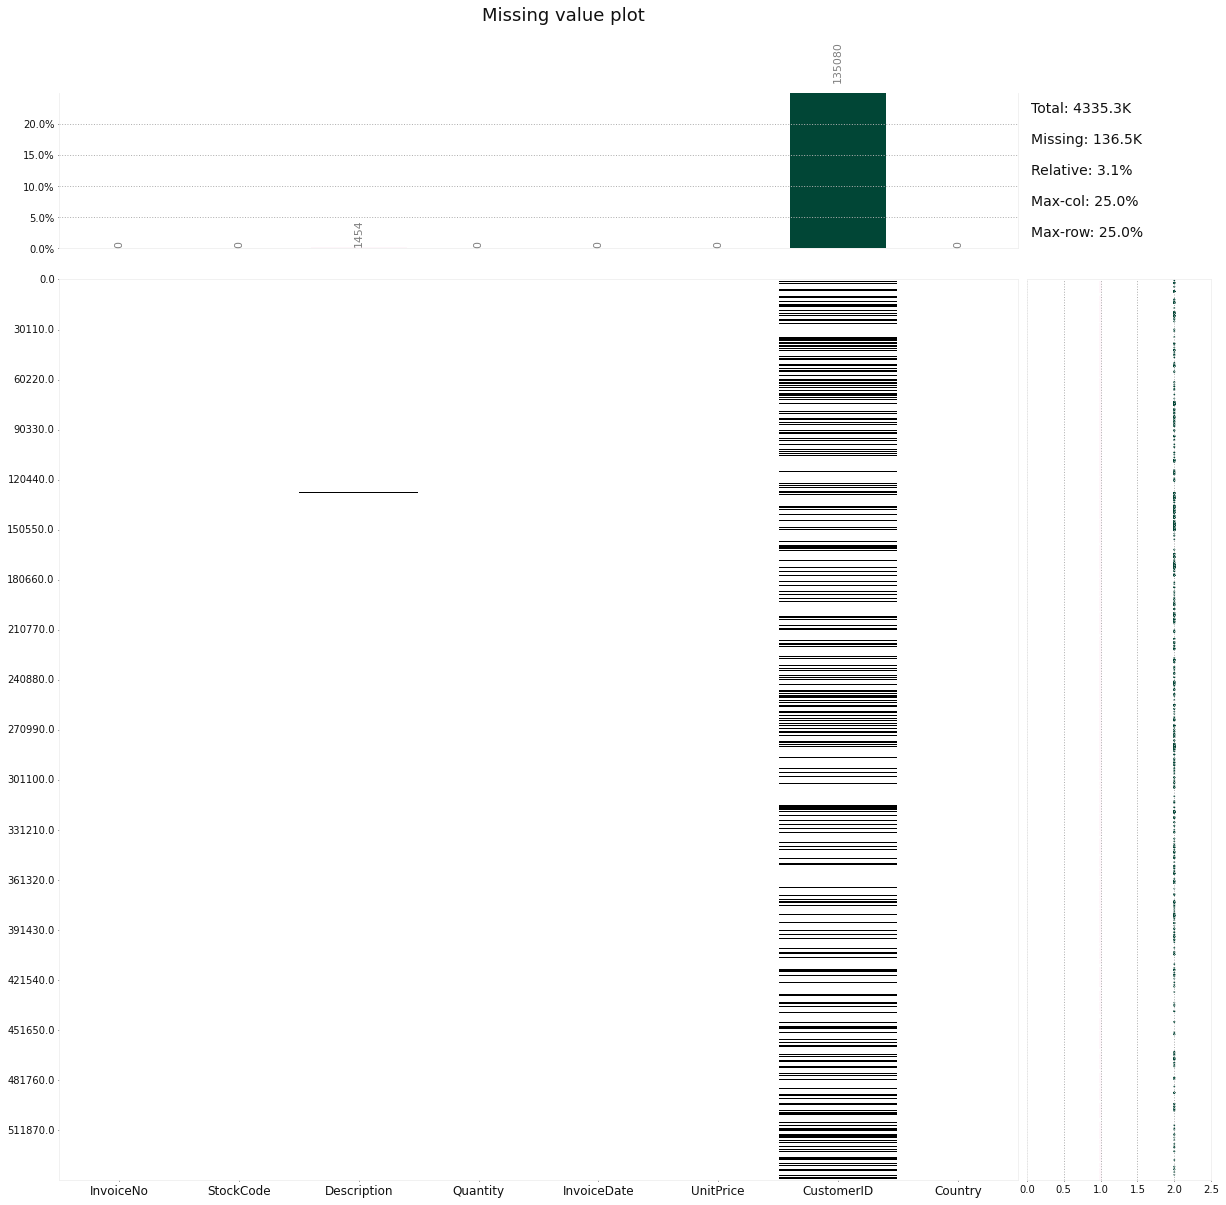

In [10]:
klib.missingval_plot(df)

# DATA QUALITY FUNCTION

In [120]:
def Quality_Check(df):
  print("*****************************************DATA SUMMARY***********************************************")
  print(Data_Summary(df))
  print("****************************************MISSING VALUES**********************************************")
  print(missing_values(df))
  print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('*'*100, 'red', attrs = ['bold']),
          colored("\nInfo:\n", attrs = ['bold']), sep = '')
  print("***************************************DUPLICATED VALUES********************************************")
  print(duplicate_values(df))
  print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('*'*100, 'red', attrs = ['bold']),
          colored("\nInfo:\n", attrs = ['bold']), sep = '')
  print(dc.duplicate_columns())
  print("*************************************MULTICOLINEARITY CHECK*****************************************")
  multicolinearity_control(df)
  print("*****************************************ERRONEOUS DATA*********************************************")
  print(ErroneousDataIdentifier(df=df).predefined_erroneous_data())


In [122]:
Quality_Check(df)

*****************************************DATA SUMMARY***********************************************
Shape:(17414, 10)
****************************************************************************************************
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB
None
*********************************************************************************